In [ ]:
import pandas as pd
import numpy as np

In [ ]:
gini = pd.read_csv('API_SI.POV.GINI_DS2_en_csv_v2_2728.csv')
gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,51.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop the 'Unnamed: 69' column if it exists and is irrelevant
if 'Unnamed: 69' in gini.columns:
    gini = gini.drop(columns=['Unnamed: 69'])

# Identify the columns that represent years (they are numeric strings)
year_columns = [col for col in gini.columns if col.isdigit() ]

# Identify the identifier columns
id_vars = [col for col in gini.columns if col not in year_columns]

# Melt the DataFrame to transform year columns into rows
gini_tidy = gini.melt(id_vars=id_vars, value_vars=year_columns, var_name='year', value_name='gini_value')

# Convert 'year' column to integer type
gini_tidy['year'] = pd.to_numeric(gini_tidy['year'])

# Display the head of the tidied DataFrame
display(gini_tidy.head())

,Country Name,Country Code,Indicator Name,Indicator Code,year,gini_value
0,Aruba,ABW,Gini index,SI.POV.GINI,1960,NaN
1,Africa Eastern and Southern,AFE,Gini index,SI.POV.GINI,1960,NaN
2,Afghanistan,AFG,Gini index,SI.POV.GINI,1960,NaN
3,Africa Western and Central,AFW,Gini index,SI.POV.GINI,1960,NaN
4,Angola,AGO,Gini index,SI.POV.GINI,1960,NaN


The `gini_tidy` DataFrame now has a 'year' column, making it easier to analyze time-series data for Gini index values.

In [ ]:
# Filter out rows with NaN gini_value
gini_no_nan = gini_tidy.dropna(subset=['gini_value'])

# Find the highest year for each country and use it to filter
gini_plot_data = gini_no_nan.loc[gini_no_nan.groupby('Country Name')['year'].idxmax()]

print(f"Data for the highest available year per country:")
print(gini_plot_data.shape)
gini_plot_data.head()

Data for the highest available year per country:
(171, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,year,gini_value
15965,Albania,ALB,Gini index,SI.POV.GINI,2020,29.4
13626,Algeria,DZA,Gini index,SI.POV.GINI,2011,27.6
15432,Angola,AGO,Gini index,SI.POV.GINI,2018,51.3
17033,Argentina,ARG,Gini index,SI.POV.GINI,2024,42.4
16768,Armenia,ARM,Gini index,SI.POV.GINI,2023,27.2


In [ ]:
gini_plot_data.gini_value.min(), gini_plot_data.gini_value.max()

(23.8, 63.0)

In [ ]:
import plotly.express as px

# Create the choropleth map for gini value of country
fig = px.choropleth(
    gini_plot_data,
    locations='Country Code',
    color='gini_value',
    hover_name='Country Name',
    color_continuous_scale='spectral_r', # Changed colorscale to blue-to-red
    range_color=[20, 60],
    title='LatestGlobal Gini Index (Blue to Red: 20 to 60)',
    projection='natural earth'
)

fig.show()

In [ ]:
from pandas_datareader import data, wb

start_year = 1990
end_year = 2022
countries = ['USA','IND','CHN','BRA','DEU']  # ISO3 codes accepted
# Indicators dictionary
indicators = {
    'NY.GDP.PCAP.KD': 'gdp_percap_const',
    'SL.UEM.TOTL.ZS': 'unemployment_pct',
    'FP.CPI.TOTL.ZG': 'inflation_pct',
    'SE.XPD.TOTL.GD.ZS': 'edu_spend_pct_gdp',
    'NE.TRD.GNFS.ZS': 'trade_pct_gdp',
    'SP.POP.TOTL': 'population'
}

from functools import reduce
frames = []
for code, name in indicators.items():
    print('Downloading', code)
    try:
        # Use wb.download, which is more robust for World Bank data and accepts 'country'
        df = wb.download(indicator=code, country=countries, start=start_year, end=end_year)
        df = df.reset_index() # country and year become columns

        # Rename columns: the indicator code to its friendly name, and 'country' to 'country_name'
        df = df.rename(columns={'country': 'country_name', code: name})

        frames.append(df[['country_name','year', name]])
    except Exception as e:
        print('Failed to fetch', code, ' — ', e)

if frames:
    data = reduce(lambda left, right: pd.merge(left, right, on=['country_name','year'], how='outer'), frames)
else:
    raise RuntimeError('No data frames fetched. Please download CSVs manually.')

data.sort_values(['country_name','year'], inplace=True)

/tmp/ipython-input-683402545.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

/tmp/ipython-input-683402545.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



/tmp/ipython-input-683402545.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



/tmp/ipython-input-683402545.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

/tmp/ipython-input-683402545.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



/tmp/ipython-input-683402545.py:22: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [ ]:
print(data.shape)
data.head()

(165, 8)


,country_name,year,gdp_percap_const,unemployment_pct,inflation_pct,edu_spend_pct_gdp,trade_pct_gdp,population
0,Brazil,1990,6149.867889,NaN,2947.732772,NaN,15.155599,149143223
1,Brazil,1991,6107.648837,6.894,432.786662,NaN,16.592078,151724256
2,Brazil,1992,5973.982856,7.086,951.962053,NaN,19.253375,154275079
3,Brazil,1993,6167.460922,6.030,1927.380790,NaN,19.599321,156794577
4,Brazil,1994,6427.169019,6.578,2075.888398,NaN,18.674760,159265006


---
# Test Brazil Data

In [ ]:
brazil = pd.read_csv('WID_data_BR.csv', sep=';')
print(brazil.shape)
brazil.head()

(543551, 7)


,country,variable,percentile,year,value,age,pop
0,BR,ehfcari999,p0p100,1990,98.971138,999,i
1,BR,ehfcari999,p0p100,1991,106.253986,999,i
2,BR,ehfcari999,p0p100,1992,104.568707,999,i
3,BR,ehfcari999,p0p100,1993,108.033348,999,i
4,BR,ehfcari999,p0p100,1994,116.849723,999,i


WID variable codes follow a structured format:

- **s** → Share (the variable measures a share of income/wealth).
- **ptinc** → Pretax income (income before taxes and transfers).
- **j** → Equal-split adults (income is split equally between partners in a household).
- **992 vs. 999** → Age group codes:
    - 992 = Adults only (age 20+)
    - 999 = All ages (entire population, including children)

In [ ]:
# we will only be calculating income share : sptinc999 = share of national income for all ages
brazil = brazil[brazil['variable'] == 'sptincj999']
print(brazil.shape)
brazil.head()

(17418, 7)


,country,variable,percentile,year,value,age,pop
265628,BR,sptincj999,p0p1,1980,0.0,999,j
265629,BR,sptincj999,p0p1,1981,0.0,999,j
265630,BR,sptincj999,p0p1,1982,0.0,999,j
265631,BR,sptincj999,p0p1,1983,0.0,999,j
265632,BR,sptincj999,p0p1,1984,0.0,999,j


In [ ]:
brazil['year'] = pd.to_datetime(brazil['year'], format='%Y').dt.year
brazil['value'] = pd.to_numeric(brazil['value'])
brazil.head()

,country,variable,percentile,year,value,age,pop
265617,BR,sptincj999,p0p1,1820,0.0001,999,j
265618,BR,sptincj999,p0p1,1850,0.0001,999,j
265619,BR,sptincj999,p0p1,1880,0.0001,999,j
265620,BR,sptincj999,p0p1,1900,0.0001,999,j
265621,BR,sptincj999,p0p1,1910,0.0001,999,j


In [ ]:
brazil = brazil[brazil['year'] >= 1980]
len(brazil)

17418

In [ ]:
brazil.head()

,country,variable,percentile,year,value,age,pop
265628,BR,sptincj999,p0p1,1980,0.0,999,j
265629,BR,sptincj999,p0p1,1981,0.0,999,j
265630,BR,sptincj999,p0p1,1982,0.0,999,j
265631,BR,sptincj999,p0p1,1983,0.0,999,j
265632,BR,sptincj999,p0p1,1984,0.0,999,j


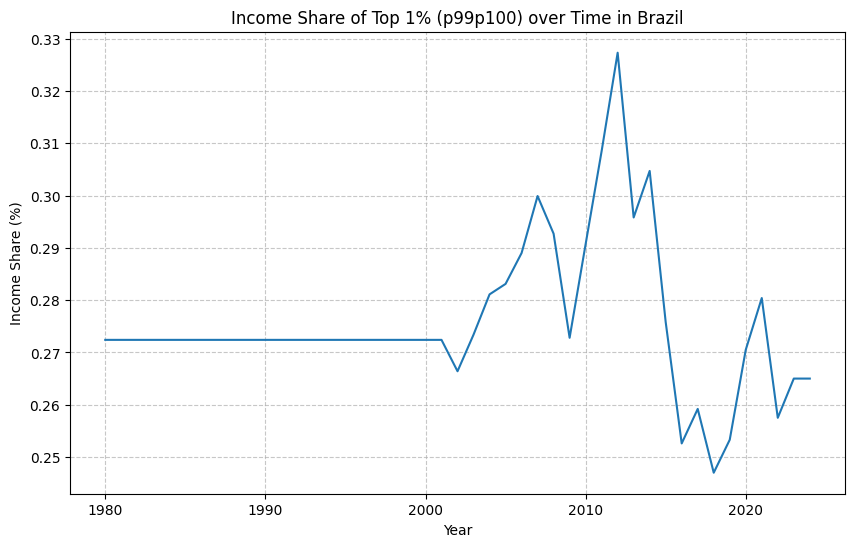

In [ ]:
from matplotlib import pyplot as plt

# Filter the brazil DataFrame for the specific percentile 'p99p100'
brazil_p99p100 = brazil[brazil['percentile'] == 'p99p100']

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(brazil_p99p100['year'], brazil_p99p100['value'])
plt.title('Income Share of Top 1% (p99p100) over Time in Brazil')
plt.ylabel('Income Share (%)')
plt.xlabel('Year')
plt.grid(True, linestyle='--', alpha=0.7)
# plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [ ]:
brazil.percentile[0].split('p')

['', '0', '100']

In [ ]:
brazil[['start_p', 'end_p']] = brazil.percentile.str[1:].str.split('p', expand=True)
brazil.head()

,country,variable,percentile,year,value,age,pop,start_p,end_p
0,BR,ehfcari999,p0p100,1990,98.971138,999,i,0,100
1,BR,ehfcari999,p0p100,1991,106.253986,999,i,0,100
2,BR,ehfcari999,p0p100,1992,104.568707,999,i,0,100
3,BR,ehfcari999,p0p100,1993,108.033348,999,i,0,100
4,BR,ehfcari999,p0p100,1994,116.849723,999,i,0,100
